<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/testing/ddpg_for_Buck_tf1_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Buck converter

In the we present the model of a buck dc-dc converter in OpenAI gym environment.

In [1]:
import numpy as np
import gym
from gym import spaces
 
import matplotlib.pyplot as plt

##Physical Model
The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+V-uV_s\\
C\dot{V} &= I-GV
\end{align}


> ![alt text](https://i.imgur.com/AdJlqEN.png)







The parameters are:


*   L - Inductance
*   C - Capacitance
*   R - Series Resistance
*   G - Load Impedance
*   $V_s$ - Source Voltage

The state variables:
*  $I\geq 0$ - current through the inductor
*  $V\geq 0$ - voltage across the Capacitor

Input:
* $u\in (0,1)$ - duty-ratio

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - (V-V_d)^2 
\end{align}




In [2]:
#@title ##Parameters

#@markdown ---

#@markdown ###System Parameters (Units in 1e-3).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 38.8 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 380 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 280 #@param {type:"slider", min: 100, max:500, step:10}


C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3


## Gym Model

In [3]:
class Buck_Converter_n(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}
 
    def __init__(self, Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 380, dt = 1e-5):
        super(Buck_Converter_n, self).__init__()
 
        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G
 
        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt
 
        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        self.Ides = self.G * self.Vdes
        self.udes = (1/self.Vs) * (1 + self.G * self.R) * self.Vdes
        self.action_des = 2*self.udes - 1
        if self.Vs <= self.Vdes:
            raise ValueError("for buck converter desired voltage should be less the source Voltage")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float64)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float64)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides*0.9, high = self.Ides*1.1)
        V = np.random.uniform(low = self.Vdes*0.9, high = self.Vdes*1.1)
        self.state = np.array([I, V])
 
    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])
 
    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])
 
    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):
 
        action = np.clip(action, -1.0, 1.0)
        u = (action + 1.0)/2.0
 
        i = self.state[0]
        v = self.state[1]
 
        didt = (-1.0/self.L)*(self.R*i + v - self.Vs*u)
        dvdt = (1.0/self.C)*(i - self.G*v)
 
        new_i = i + self.T * didt
        new_v = v + self.T * dvdt
 
        self.state = np.array([new_i, new_v]).astype(np.float32)
 
        # normalize the rewards
        reward = -np.abs(new_v-self.Vdes)#-np.abs(new_i-self.Ides)#((new_v-self.Vdes)/20.0)**2
        done = False
        return self.state, reward, done, {}
 
    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))
 
    def close(self):
        pass

## Testing

In [4]:
def plot_signals(data, Ides, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i])
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(0, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage', fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

### Constant input policy

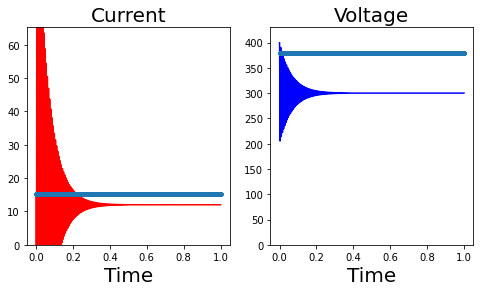

In [5]:
env = Buck_Converter_n()

env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(0.5)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

### Stabilizing  input policy

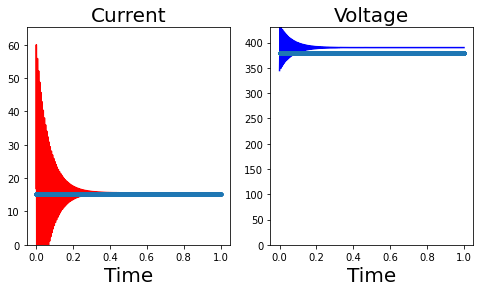

In [6]:
env.reset()

obs = []
for i in range(10**5):
    s, r, _, _ = env.step(env.udes)
    obs.append(s)

trajectory = np.concatenate(obs).reshape((10**5 ,env.observation_space.shape[0]))
plot_signals(trajectory, env.Ides, env.Vdes, dt = 1e-5)

#Utilities

## Replay Buffer

In [7]:
""" 
Data structure for implementing experience replay
Author: Patrick Emami
"""
from collections import deque
import random
import numpy as np

class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

## OU Noise

In [8]:
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-5, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

## Plot

In [9]:
##Plotting
import matplotlib.pyplot as plt

def plot_signals(data, actions, reward, Ides, Vdes, udes):
    dt=1e-5
    number_of_colors = data.shape[1]
    color = ['r', 'b','g','g']
    lim = [50,50,1.1,1.1]
    des = [Ides, Vdes, udes, 0]
    titles = ['Current', 'Voltage', 'duty-ratio', 'reward']
    time = np.array(range(data.shape[0]), dtype=np.float32)*dt
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1]+ actions.shape[1] + 1, figsize = (16,4))
    for i in range(data.shape[1]):
        ax[i].plot(time, data[:, i],  c = color[i], marker ='o')
        ax[i].plot(time, np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(des[i]-lim[i], des[i]+lim[i])
        ax[i].set_title(titles[i], fontsize=20)
        ax[i].set_xlabel('Time', fontsize=20)
    for j in range(actions.shape[1]):
        i = data.shape[1] + j
        ax[i].plot(time, actions[:, j],  c = color[i], marker ='o')
        ax[i].plot(time, np.full(actions[:,j].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(-lim[i], lim[i])
        ax[i].set_title(titles[i], fontsize=20)
        ax[i].set_xlabel('Time', fontsize=20)

    ax[i+1].plot(time, reward, marker = '.')
    ax[i+1].set_ylim(min(reward), 0)
    ax[i+1].set_title(titles[i+1], fontsize=20)
    ax[i+1].set_xlabel('Time', fontsize=20)    
    plt.show()


def plot_signals2(data, actions, reward, x, Ides, Vdes):
    number_of_colors = data.shape[1]
    color = ['r', 'b']
    des = [Ides, Vdes]
    fig, ax = plt.subplots(nrows=1, ncols=data.shape[1], figsize = (8,4))
    for i in range(data.shape[1]):
        ax[i].plot(range(data.shape[0]), data[:, i],  c = color[i], marker ='o')
        ax[i].plot(range(data.shape[0]), np.full(data[:,i].shape[0], des[i]), marker = '.')
        ax[i].set_ylim(des[i]-50, des[i]+50)
    ax[0].set_title('Current', fontsize=20)
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_title('Voltage'.format(x), fontsize=20)
    ax[1].set_xlabel('Time', fontsize=20)
    plt.show()

def test_plot(actor):
    test_env = Buck_Converter_n(L = 0.001, C = 0.002, R = 0.001, G = .04, Vs = 400, Vdes = 200, dt = 1e-5)
    test_s = test_env.reset()
    test_obs, test_act, test_rew =[], [], []
    test_steps = 10**3
    for test_i in range(test_steps):
        test_a = actor.predict(np.reshape(test_s,(1,actor.s_dim)))
        test_a = np.clip(test_a, -1, 1)  
        test_s, test_r, _, _ = test_env.step(test_a[0])
        test_obs.append(test_s)
        test_act.append(test_a)
        test_rew.append(test_r)
    
    test_obs_reshape = np.concatenate(test_obs).reshape((test_steps ,test_env.observation_space.shape[0]))
    test_act_reshape = np.concatenate(test_act).reshape((test_steps ,1))
    
    plot_signals(test_obs_reshape, test_act_reshape, test_rew,test_env.Ides, test_env.Vdes, test_env.action_des)



#DDPG

In [10]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import tflearn
import argparse
import pprint as pp

TensorFlow 1.x selected.








##Actor Network

In [11]:
# ===========================
#   Actor and Critic DNNs
# ===========================

class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
            len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).\
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 300)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init)
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars


## Critic Network

In [12]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.
    """

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 300)
        t2 = tflearn.fully_connected(action, 300)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

## Tensorflow Summary Ops



In [13]:
def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("Qmax Value", episode_ave_max_q)

    summary_vars = [episode_reward, episode_ave_max_q]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars

## Train

In [14]:
def train(sess, env, args, actor, critic, actor_noise, reward_result):

    # Set up summary Ops
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(args['summary_dir'], sess.graph)

    # Initialize target network weights
    actor.update_target_network()
    critic.update_target_network()

    # Initialize replay memory
    replay_buffer = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))

    # Needed to enable BatchNorm. 
    # This hurts the performance on Pendulum but could be useful
    # in other environments.
    # tflearn.is_training(True)

    paths = list()
    
    for i in range(int(args['max_episodes'])):

        s = env.reset()

        ep_reward = 0
        ep_ave_max_q = 0

        obs, action, rewards = [], [], []
        
        for j in range(int(args['max_episode_len'])):
            
            #env.render()


            # Added exploration noise
            #a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            a = actor.predict(np.reshape(s, (1, actor.s_dim))) + actor_noise()*((1. / (1. + i/100)))

            s2, r, terminal, info = env.step(a[0])

            replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r,
                              terminal, np.reshape(s2, (actor.s_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > int(args['minibatch_size']):
                s_batch, a_batch, r_batch, t_batch, s2_batch = \
                    replay_buffer.sample_batch(int(args['minibatch_size']))

                # Calculate targets
                target_q = critic.predict_target(
                    s2_batch, actor.predict_target(s2_batch))

                y_i = []
                for k in range(int(args['minibatch_size'])):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + critic.gamma * target_q[k])

                # Update the critic given the targets
                predicted_q_value, _ = critic.train(
                    s_batch, a_batch, np.reshape(y_i, (int(args['minibatch_size']), 1)))

                ep_ave_max_q += np.amax(predicted_q_value)

                # Update the actor policy using the sampled gradient
                a_outs = actor.predict(s_batch)
                grads = critic.action_gradients(s_batch, a_outs)
                actor.train(s_batch, grads[0])

                # Update target networks
                actor.update_target_network()
                critic.update_target_network()

            s = s2
            ep_reward += r

            obs.append(s)
            rewards.append(r)
            action.append(a[0])

            if terminal | j+1 == int(args['max_episode_len']):

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j)
                })

                writer.add_summary(summary_str, i)
                writer.flush()
                reshaped_obs = np.concatenate(obs).reshape((j+1 ,env.observation_space.shape[0]))
                reshaped_act = np.concatenate(action).reshape((j+1 ,env.action_space.shape[0]))
                if i%10 == 0:
                    plot_signals(reshaped_obs, reshaped_act, rewards, env.Ides, env.Vdes, env.action_des)

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f}'.format(int(ep_reward), \
                        i, (ep_ave_max_q / float(j))))
                reward_result[i] = ep_reward
                path = {"Observation":np.concatenate(obs).reshape((j+1 ,env.observation_space.shape[0])),
                        "Action":np.concatenate(action),
		        "Reward":np.asarray(rewards)}
                paths.append(path)

                break

    return [summary_ops, summary_vars, paths]

#Run

##Args

In [15]:
args = {'env':'Buck_Converter_n',
        'random_seed':1234,
        'actor_lr':0.0001,
        'critic_lr':0.001,
        'tau':0.001,
        'gamma':0.99,
        'minibatch_size':100,
        'use_gym_monitor':False,
        'render_env':False,
        'buffer_size':1000000,
        'max_episodes':2000,
        'max_episode_len':1000,
        'monitor_dir':'/content/sample_data',
        'summary_dir':'/content/sample_data'
        }



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Summary name Qmax Value is illegal; using Qmax_Value instead.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


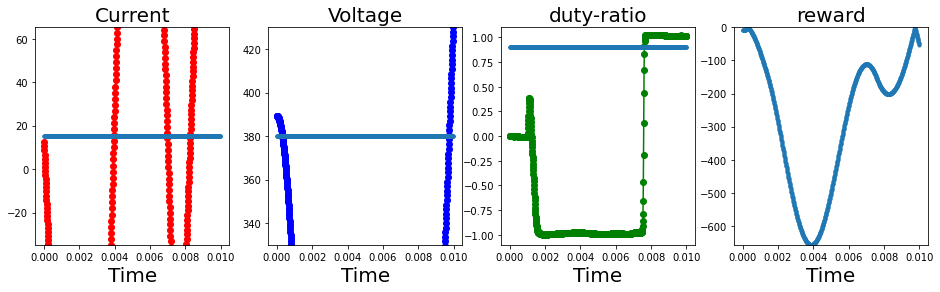

| Reward: -276073 | Episode: 0 | Qmax: -13.2777
| Reward: -344375 | Episode: 1 | Qmax: 4.6972
| Reward: -384078 | Episode: 2 | Qmax: 33.7736
| Reward: -376459 | Episode: 3 | Qmax: 32.8755
| Reward: -374428 | Episode: 4 | Qmax: 23.2115
| Reward: -357596 | Episode: 5 | Qmax: -21.5322
| Reward: -32929 | Episode: 6 | Qmax: -59.4305
| Reward: -19365 | Episode: 7 | Qmax: -44.1593
| Reward: -20020 | Episode: 8 | Qmax: -51.9510
| Reward: -20101 | Episode: 9 | Qmax: -64.1925


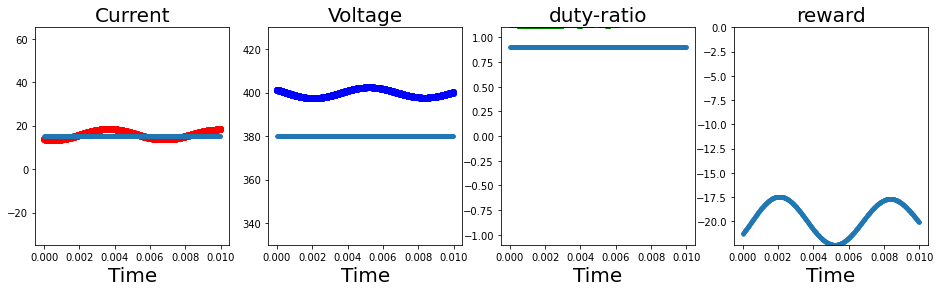

| Reward: -19532 | Episode: 10 | Qmax: -76.4133
| Reward: -21046 | Episode: 11 | Qmax: -80.4334
| Reward: -20566 | Episode: 12 | Qmax: -85.2776
| Reward: -33526 | Episode: 13 | Qmax: -92.7129
| Reward: -19561 | Episode: 14 | Qmax: -93.9088
| Reward: -20265 | Episode: 15 | Qmax: -101.2743
| Reward: -26962 | Episode: 16 | Qmax: -106.6275
| Reward: -23424 | Episode: 17 | Qmax: -111.5247
| Reward: -36737 | Episode: 18 | Qmax: -110.7608
| Reward: -20651 | Episode: 19 | Qmax: -116.3869


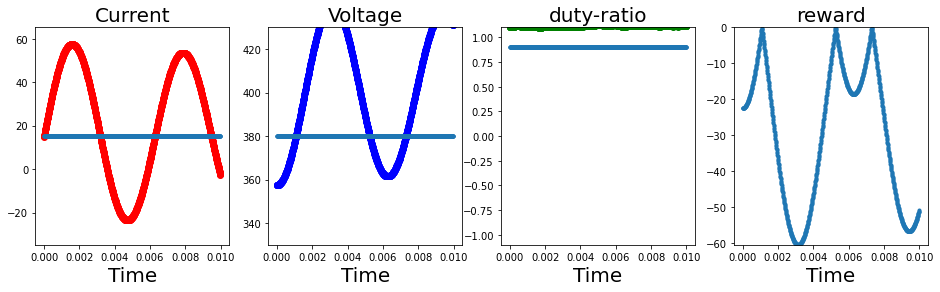

| Reward: -29934 | Episode: 20 | Qmax: -118.4686
| Reward: -20743 | Episode: 21 | Qmax: -124.3564
| Reward: -28308 | Episode: 22 | Qmax: -129.2365
| Reward: -19709 | Episode: 23 | Qmax: -128.1892
| Reward: -35931 | Episode: 24 | Qmax: -133.4759
| Reward: -19305 | Episode: 25 | Qmax: -137.0148
| Reward: -20243 | Episode: 26 | Qmax: -140.8416
| Reward: -33485 | Episode: 27 | Qmax: -143.5352
| Reward: -20141 | Episode: 28 | Qmax: -149.1925
| Reward: -36462 | Episode: 29 | Qmax: -152.7309


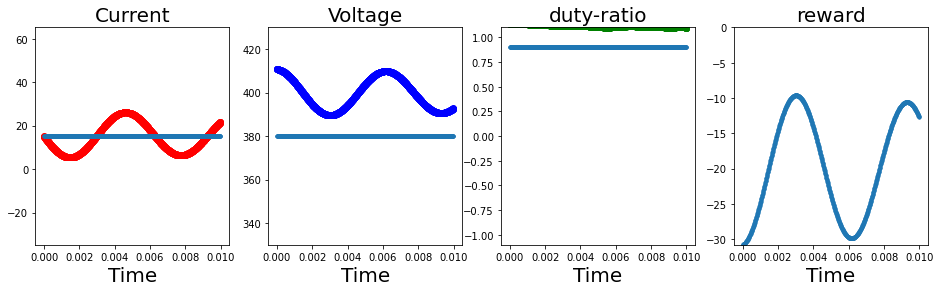

| Reward: -19315 | Episode: 30 | Qmax: -159.3794
| Reward: -36427 | Episode: 31 | Qmax: -160.6077
| Reward: -19201 | Episode: 32 | Qmax: -163.1678
| Reward: -20018 | Episode: 33 | Qmax: -168.2856
| Reward: -25869 | Episode: 34 | Qmax: -172.0124
| Reward: -19527 | Episode: 35 | Qmax: -177.1561
| Reward: -19239 | Episode: 36 | Qmax: -170.0129
| Reward: -28441 | Episode: 37 | Qmax: -171.5948
| Reward: -19816 | Episode: 38 | Qmax: -177.7748
| Reward: -19997 | Episode: 39 | Qmax: -181.2818


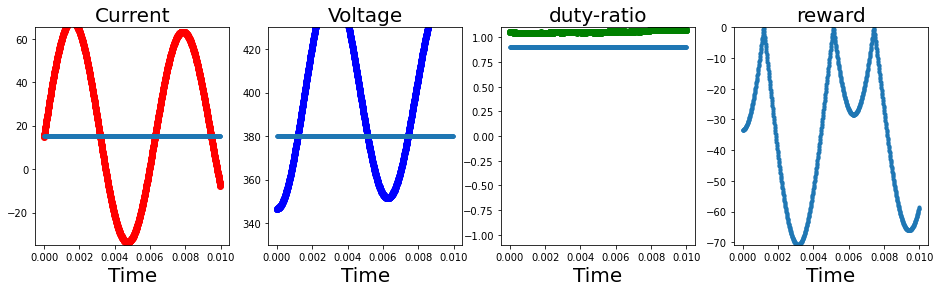

| Reward: -35871 | Episode: 40 | Qmax: -185.1396
| Reward: -19144 | Episode: 41 | Qmax: -188.5588
| Reward: -33201 | Episode: 42 | Qmax: -192.0557
| Reward: -19386 | Episode: 43 | Qmax: -197.1110
| Reward: -20371 | Episode: 44 | Qmax: -203.8456
| Reward: -32548 | Episode: 45 | Qmax: -202.1756
| Reward: -35237 | Episode: 46 | Qmax: -208.8149
| Reward: -22241 | Episode: 47 | Qmax: -213.1959
| Reward: -19154 | Episode: 48 | Qmax: -218.7689
| Reward: -19588 | Episode: 49 | Qmax: -228.9607


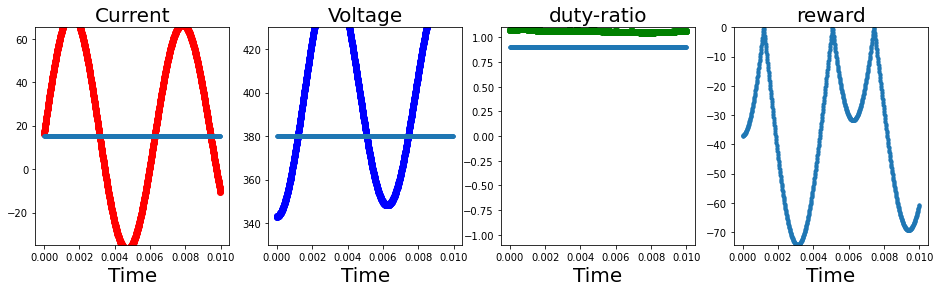

| Reward: -37995 | Episode: 50 | Qmax: -227.3441
| Reward: -20319 | Episode: 51 | Qmax: -235.8529
| Reward: -20046 | Episode: 52 | Qmax: -236.9840
| Reward: -19780 | Episode: 53 | Qmax: -246.1231
| Reward: -20900 | Episode: 54 | Qmax: -256.9701
| Reward: -20718 | Episode: 55 | Qmax: -263.4353
| Reward: -38178 | Episode: 56 | Qmax: -262.3818
| Reward: -19136 | Episode: 57 | Qmax: -266.9723
| Reward: -19449 | Episode: 58 | Qmax: -272.8677
| Reward: -25084 | Episode: 59 | Qmax: -277.8947


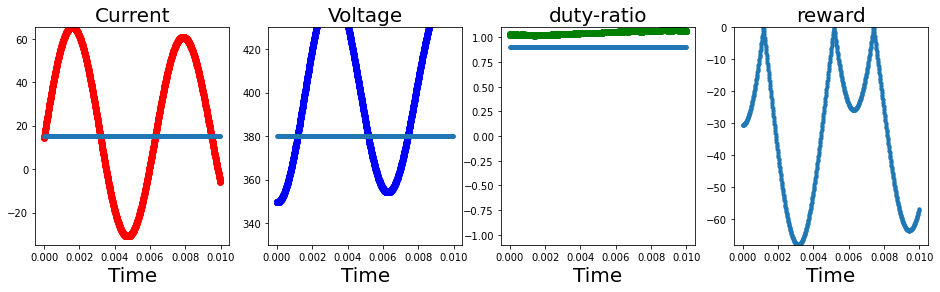

| Reward: -34264 | Episode: 60 | Qmax: -284.2301
| Reward: -31673 | Episode: 61 | Qmax: -260.7385
| Reward: -23599 | Episode: 62 | Qmax: -218.4043
| Reward: -23913 | Episode: 63 | Qmax: -222.5530
| Reward: -19712 | Episode: 64 | Qmax: -225.4963
| Reward: -22606 | Episode: 65 | Qmax: -232.0388
| Reward: -34472 | Episode: 66 | Qmax: -236.6828
| Reward: -20021 | Episode: 67 | Qmax: -235.9761
| Reward: -35909 | Episode: 68 | Qmax: -244.3111
| Reward: -19618 | Episode: 69 | Qmax: -245.6971


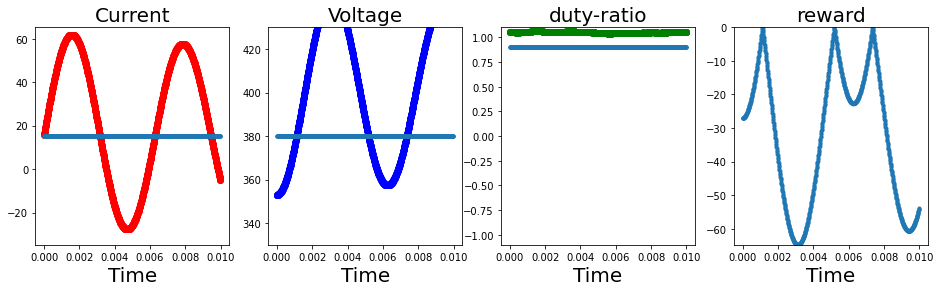

| Reward: -32403 | Episode: 70 | Qmax: -231.6795
| Reward: -20234 | Episode: 71 | Qmax: -236.5073
| Reward: -20572 | Episode: 72 | Qmax: -241.3003
| Reward: -29156 | Episode: 73 | Qmax: -246.2389
| Reward: -21891 | Episode: 74 | Qmax: -250.2710
| Reward: -31671 | Episode: 75 | Qmax: -257.4228
| Reward: -19202 | Episode: 76 | Qmax: -269.9453
| Reward: -18867 | Episode: 77 | Qmax: -259.2545
| Reward: -20771 | Episode: 78 | Qmax: -254.5064
| Reward: -20621 | Episode: 79 | Qmax: -259.9211


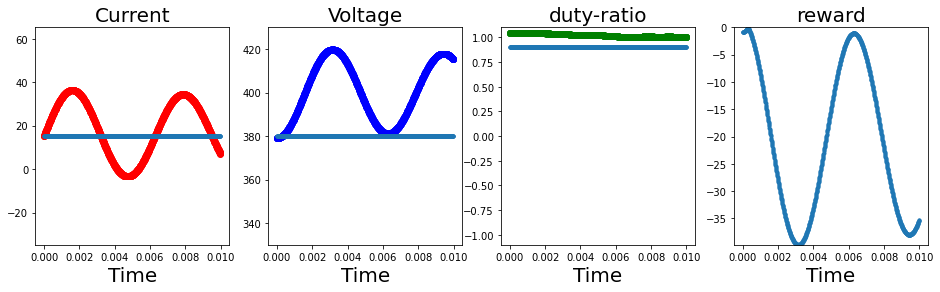

| Reward: -20841 | Episode: 80 | Qmax: -263.2528
| Reward: -20733 | Episode: 81 | Qmax: -269.1375
| Reward: -25969 | Episode: 82 | Qmax: -269.6269
| Reward: -30034 | Episode: 83 | Qmax: -276.9126
| Reward: -20434 | Episode: 84 | Qmax: -277.6346
| Reward: -34070 | Episode: 85 | Qmax: -282.6898
| Reward: -27618 | Episode: 86 | Qmax: -284.1611
| Reward: -20358 | Episode: 87 | Qmax: -283.7907
| Reward: -19620 | Episode: 88 | Qmax: -291.9225
| Reward: -22995 | Episode: 89 | Qmax: -296.0928


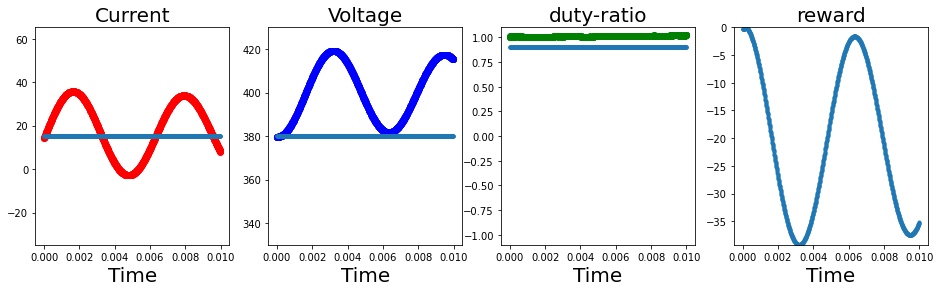

| Reward: -20627 | Episode: 90 | Qmax: -304.1551
| Reward: -19387 | Episode: 91 | Qmax: -306.2966
| Reward: -19364 | Episode: 92 | Qmax: -312.9944
| Reward: -20332 | Episode: 93 | Qmax: -326.3509
| Reward: -21615 | Episode: 94 | Qmax: -315.9729
| Reward: -37597 | Episode: 95 | Qmax: -323.0791
| Reward: -32720 | Episode: 96 | Qmax: -322.7643
| Reward: -20694 | Episode: 97 | Qmax: -325.7875
| Reward: -20278 | Episode: 98 | Qmax: -327.6374
| Reward: -20420 | Episode: 99 | Qmax: -332.3902


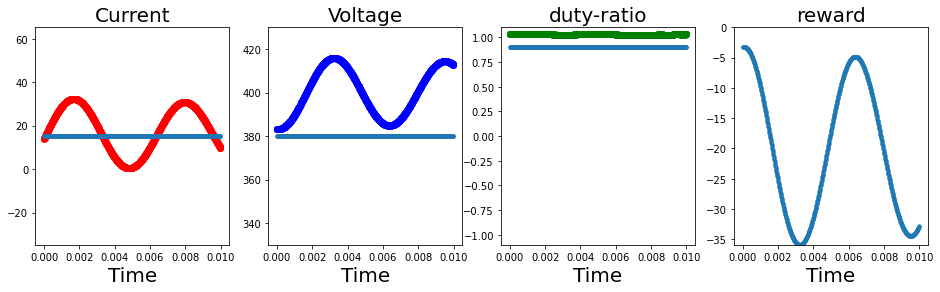

| Reward: -20414 | Episode: 100 | Qmax: -339.9009
| Reward: -34613 | Episode: 101 | Qmax: -347.2206
| Reward: -36067 | Episode: 102 | Qmax: -346.1321
| Reward: -32173 | Episode: 103 | Qmax: -349.2593
| Reward: -14271 | Episode: 104 | Qmax: -352.7687
| Reward: -17927 | Episode: 105 | Qmax: -353.5894
| Reward: -13946 | Episode: 106 | Qmax: -360.0220
| Reward: -17927 | Episode: 107 | Qmax: -360.5100
| Reward: -15953 | Episode: 108 | Qmax: -372.2275
| Reward: -16169 | Episode: 109 | Qmax: -365.5283


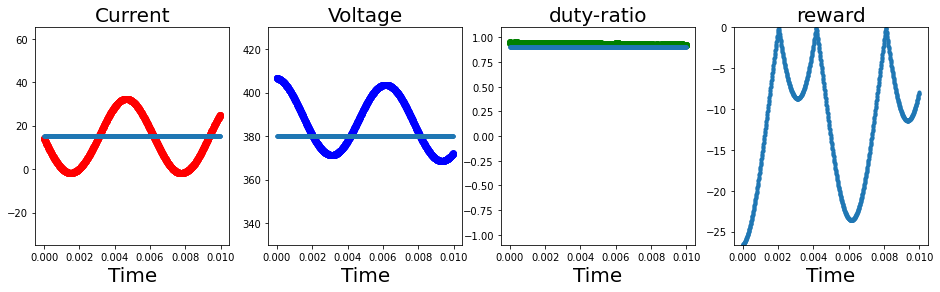

| Reward: -11728 | Episode: 110 | Qmax: -369.1965
| Reward: -7333 | Episode: 111 | Qmax: -374.0581
| Reward: -16260 | Episode: 112 | Qmax: -374.8076
| Reward: -6804 | Episode: 113 | Qmax: -375.2095
| Reward: -22252 | Episode: 114 | Qmax: -387.0093
| Reward: -4807 | Episode: 115 | Qmax: -389.6029
| Reward: -19970 | Episode: 116 | Qmax: -380.5997
| Reward: -5673 | Episode: 117 | Qmax: -384.1004
| Reward: -13825 | Episode: 118 | Qmax: -383.6686
| Reward: -4952 | Episode: 119 | Qmax: -382.8584


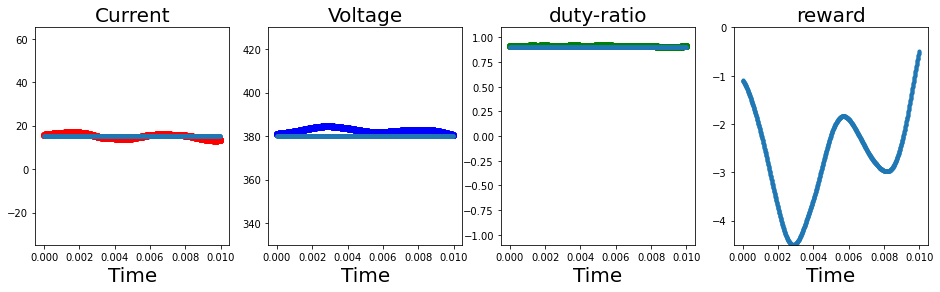

| Reward: -2693 | Episode: 120 | Qmax: -383.5395
| Reward: -2515 | Episode: 121 | Qmax: -390.1248
| Reward: -13536 | Episode: 122 | Qmax: -393.6395
| Reward: -21428 | Episode: 123 | Qmax: -390.8969
| Reward: -18290 | Episode: 124 | Qmax: -389.3991
| Reward: -3954 | Episode: 125 | Qmax: -393.6867
| Reward: -4912 | Episode: 126 | Qmax: -399.1322
| Reward: -2055 | Episode: 127 | Qmax: -399.6652
| Reward: -3830 | Episode: 128 | Qmax: -399.1225
| Reward: -20701 | Episode: 129 | Qmax: -410.7680


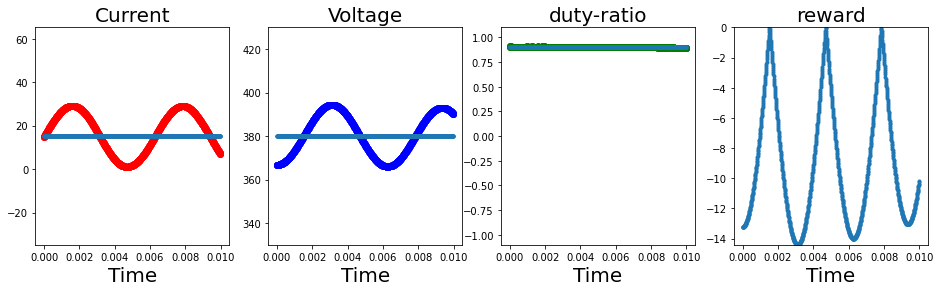

| Reward: -9030 | Episode: 130 | Qmax: -406.1066
| Reward: -19762 | Episode: 131 | Qmax: -405.1244
| Reward: -6317 | Episode: 132 | Qmax: -408.7900
| Reward: -17070 | Episode: 133 | Qmax: -413.9947
| Reward: -3130 | Episode: 134 | Qmax: -414.6102
| Reward: -21883 | Episode: 135 | Qmax: -418.8012
| Reward: -4391 | Episode: 136 | Qmax: -421.6875
| Reward: -15014 | Episode: 137 | Qmax: -425.7687
| Reward: -15927 | Episode: 138 | Qmax: -422.6601
| Reward: -7193 | Episode: 139 | Qmax: -425.1206


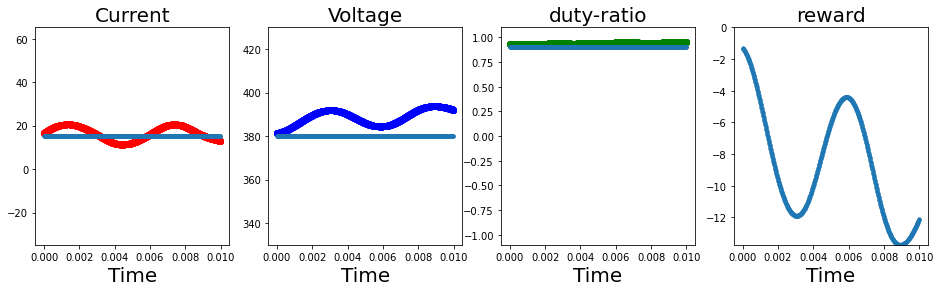

| Reward: -8669 | Episode: 140 | Qmax: -426.0758
| Reward: -18049 | Episode: 141 | Qmax: -428.4591
| Reward: -10926 | Episode: 142 | Qmax: -429.4937
| Reward: -15774 | Episode: 143 | Qmax: -429.0279
| Reward: -17315 | Episode: 144 | Qmax: -431.9488
| Reward: -18070 | Episode: 145 | Qmax: -434.4255
| Reward: -18116 | Episode: 146 | Qmax: -431.3446
| Reward: -24598 | Episode: 147 | Qmax: -433.6543
| Reward: -18692 | Episode: 148 | Qmax: -438.2269
| Reward: -30318 | Episode: 149 | Qmax: -433.7782


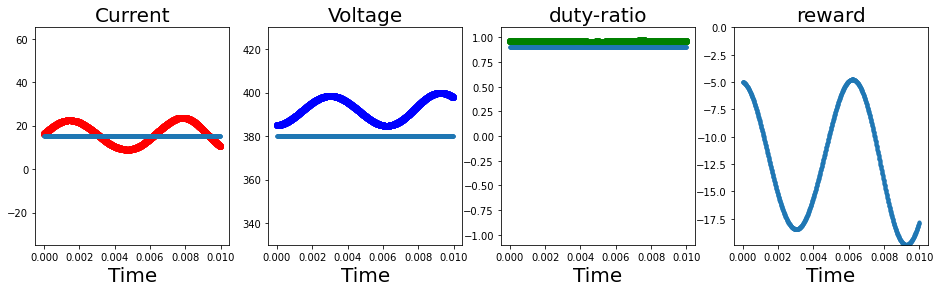

| Reward: -12479 | Episode: 150 | Qmax: -437.3574
| Reward: -15369 | Episode: 151 | Qmax: -437.2269
| Reward: -12946 | Episode: 152 | Qmax: -436.0001
| Reward: -5603 | Episode: 153 | Qmax: -433.8321
| Reward: -8743 | Episode: 154 | Qmax: -436.8282
| Reward: -10639 | Episode: 155 | Qmax: -435.3667
| Reward: -27281 | Episode: 156 | Qmax: -434.3481
| Reward: -12589 | Episode: 157 | Qmax: -438.5858
| Reward: -24950 | Episode: 158 | Qmax: -436.1248
| Reward: -7881 | Episode: 159 | Qmax: -438.4210


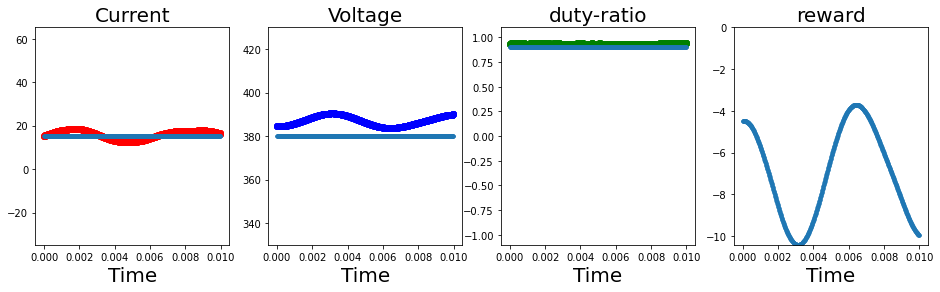

| Reward: -6969 | Episode: 160 | Qmax: -438.8097
| Reward: -8464 | Episode: 161 | Qmax: -442.6025
| Reward: -27668 | Episode: 162 | Qmax: -441.3259
| Reward: -11891 | Episode: 163 | Qmax: -435.5906
| Reward: -21352 | Episode: 164 | Qmax: -440.2932
| Reward: -9829 | Episode: 165 | Qmax: -440.2919
| Reward: -8459 | Episode: 166 | Qmax: -445.0414
| Reward: -16677 | Episode: 167 | Qmax: -445.5310
| Reward: -6282 | Episode: 168 | Qmax: -443.8123
| Reward: -12583 | Episode: 169 | Qmax: -446.8949


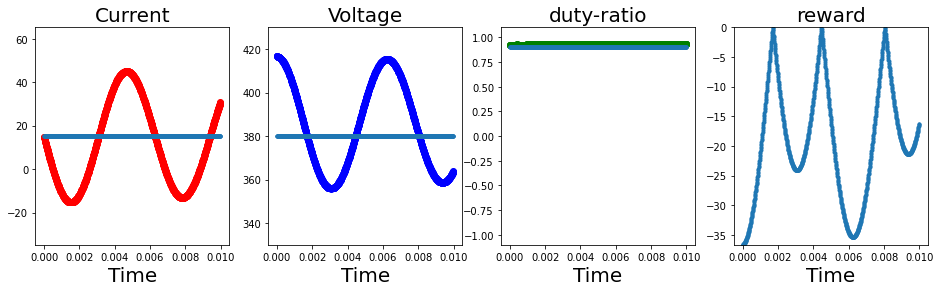

| Reward: -19173 | Episode: 170 | Qmax: -447.6366
| Reward: -8341 | Episode: 171 | Qmax: -450.1454
| Reward: -11339 | Episode: 172 | Qmax: -444.1024
| Reward: -10399 | Episode: 173 | Qmax: -446.7714
| Reward: -18871 | Episode: 174 | Qmax: -449.4841
| Reward: -16634 | Episode: 175 | Qmax: -446.1218
| Reward: -28762 | Episode: 176 | Qmax: -447.4991
| Reward: -9723 | Episode: 177 | Qmax: -450.6643
| Reward: -11859 | Episode: 178 | Qmax: -446.1672
| Reward: -14080 | Episode: 179 | Qmax: -448.5978


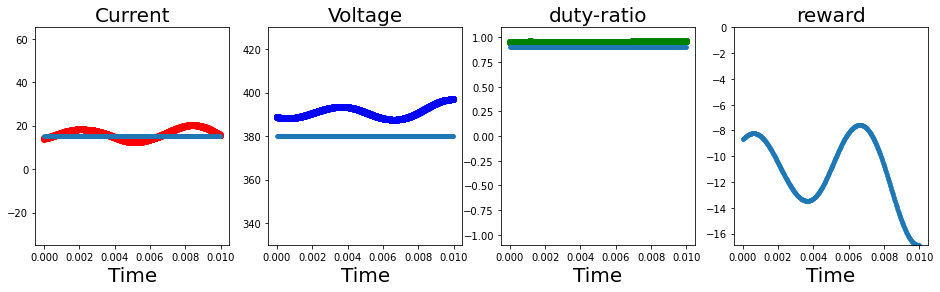

| Reward: -11041 | Episode: 180 | Qmax: -448.5541
| Reward: -13006 | Episode: 181 | Qmax: -450.1546
| Reward: -30631 | Episode: 182 | Qmax: -453.9039
| Reward: -17160 | Episode: 183 | Qmax: -455.3082
| Reward: -18016 | Episode: 184 | Qmax: -455.7748
| Reward: -18184 | Episode: 185 | Qmax: -458.2164
| Reward: -19869 | Episode: 186 | Qmax: -464.5049
| Reward: -14055 | Episode: 187 | Qmax: -463.1547
| Reward: -25220 | Episode: 188 | Qmax: -464.2844
| Reward: -23931 | Episode: 189 | Qmax: -462.5033


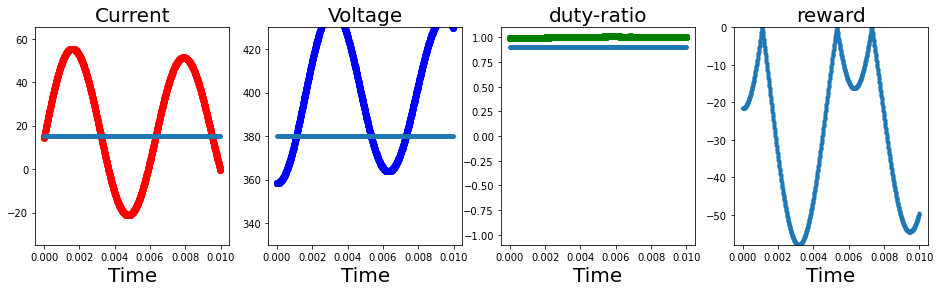

| Reward: -28583 | Episode: 190 | Qmax: -468.9159
| Reward: -21737 | Episode: 191 | Qmax: -471.0986
| Reward: -20283 | Episode: 192 | Qmax: -469.8188
| Reward: -30045 | Episode: 193 | Qmax: -469.2740
| Reward: -18618 | Episode: 194 | Qmax: -470.4078
| Reward: -17482 | Episode: 195 | Qmax: -477.6916
| Reward: -14950 | Episode: 196 | Qmax: -476.8002
| Reward: -32426 | Episode: 197 | Qmax: -480.4723
| Reward: -33192 | Episode: 198 | Qmax: -482.9506
| Reward: -19773 | Episode: 199 | Qmax: -484.7273


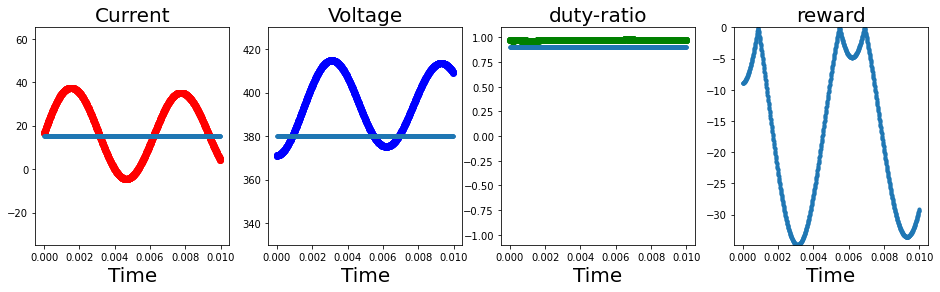

| Reward: -17450 | Episode: 200 | Qmax: -483.3072
| Reward: -15404 | Episode: 201 | Qmax: -483.1802
| Reward: -16966 | Episode: 202 | Qmax: -483.6195
| Reward: -16535 | Episode: 203 | Qmax: -488.0582
| Reward: -16163 | Episode: 204 | Qmax: -488.8425
| Reward: -16046 | Episode: 205 | Qmax: -485.7000
| Reward: -31095 | Episode: 206 | Qmax: -488.8142
| Reward: -16013 | Episode: 207 | Qmax: -488.4061
| Reward: -22102 | Episode: 208 | Qmax: -484.8176
| Reward: -18357 | Episode: 209 | Qmax: -489.6655


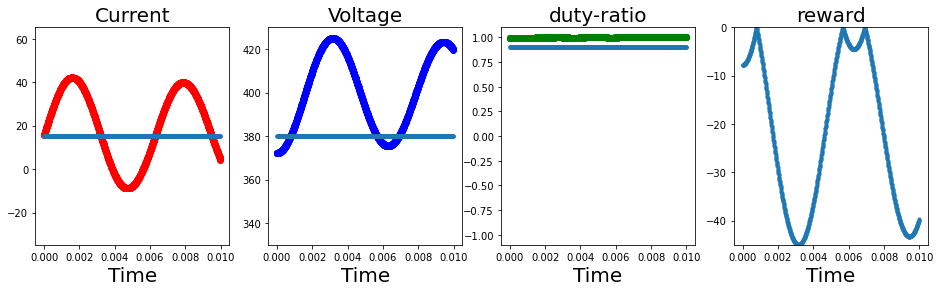

| Reward: -22272 | Episode: 210 | Qmax: -487.4877
| Reward: -20056 | Episode: 211 | Qmax: -486.9240
| Reward: -19599 | Episode: 212 | Qmax: -490.5980
| Reward: -24483 | Episode: 213 | Qmax: -490.4446
| Reward: -24772 | Episode: 214 | Qmax: -487.9962
| Reward: -12299 | Episode: 215 | Qmax: -490.6724
| Reward: -31818 | Episode: 216 | Qmax: -487.8101
| Reward: -11435 | Episode: 217 | Qmax: -491.2747
| Reward: -12411 | Episode: 218 | Qmax: -489.8887
| Reward: -11189 | Episode: 219 | Qmax: -489.4530


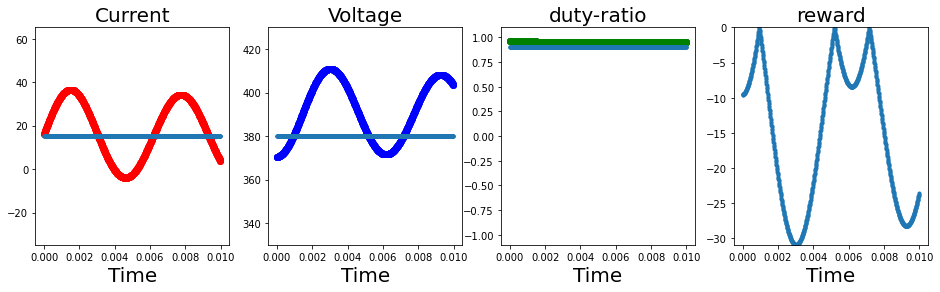

| Reward: -15189 | Episode: 220 | Qmax: -492.2807
| Reward: -13483 | Episode: 221 | Qmax: -491.4360
| Reward: -26563 | Episode: 222 | Qmax: -492.8574
| Reward: -12589 | Episode: 223 | Qmax: -490.2686
| Reward: -16190 | Episode: 224 | Qmax: -487.5027
| Reward: -28979 | Episode: 225 | Qmax: -491.3990
| Reward: -14591 | Episode: 226 | Qmax: -486.1197
| Reward: -9120 | Episode: 227 | Qmax: -486.0858
| Reward: -21954 | Episode: 228 | Qmax: -492.8686
| Reward: -21895 | Episode: 229 | Qmax: -489.0235


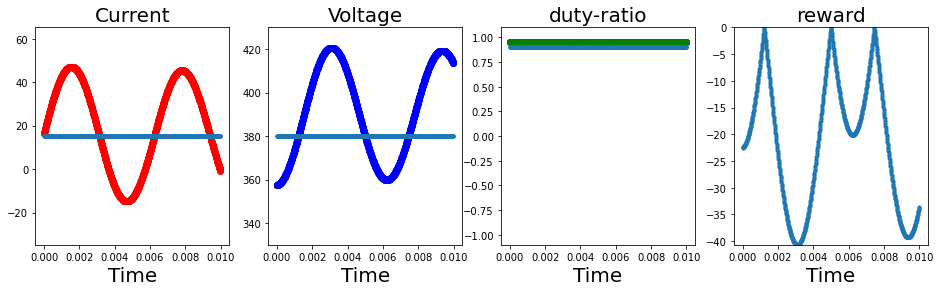

| Reward: -21529 | Episode: 230 | Qmax: -490.2826
| Reward: -28247 | Episode: 231 | Qmax: -490.1767
| Reward: -9671 | Episode: 232 | Qmax: -492.9734
| Reward: -14854 | Episode: 233 | Qmax: -490.9445
| Reward: -11838 | Episode: 234 | Qmax: -493.7938
| Reward: -16947 | Episode: 235 | Qmax: -488.4528
| Reward: -20710 | Episode: 236 | Qmax: -490.1296
| Reward: -7667 | Episode: 237 | Qmax: -488.9190
| Reward: -18794 | Episode: 238 | Qmax: -492.7180
| Reward: -19150 | Episode: 239 | Qmax: -491.4669


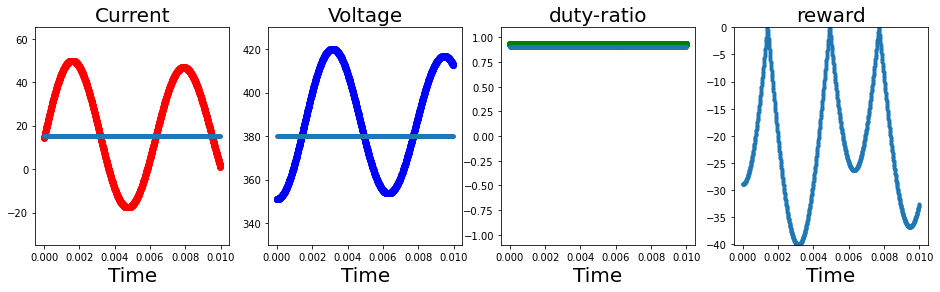

| Reward: -22172 | Episode: 240 | Qmax: -492.1880
| Reward: -23249 | Episode: 241 | Qmax: -495.1529
| Reward: -6675 | Episode: 242 | Qmax: -488.9396
| Reward: -6659 | Episode: 243 | Qmax: -490.5404
| Reward: -6985 | Episode: 244 | Qmax: -487.8027
| Reward: -10740 | Episode: 245 | Qmax: -488.4807
| Reward: -4216 | Episode: 246 | Qmax: -483.7790
| Reward: -17448 | Episode: 247 | Qmax: -482.9912
| Reward: -5493 | Episode: 248 | Qmax: -485.8803
| Reward: -18266 | Episode: 249 | Qmax: -485.8412


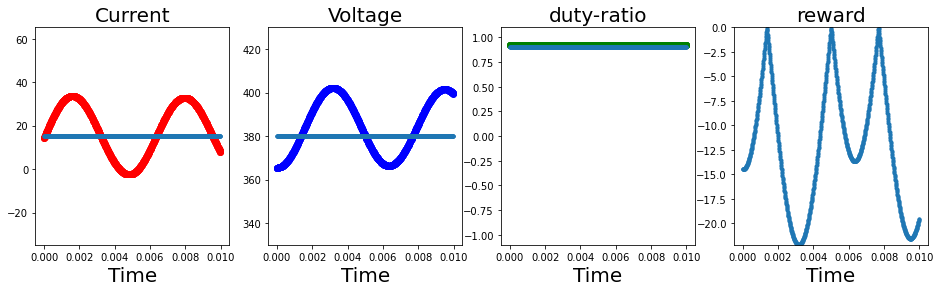

| Reward: -12206 | Episode: 250 | Qmax: -482.7908
| Reward: -16662 | Episode: 251 | Qmax: -488.4689
| Reward: -3807 | Episode: 252 | Qmax: -486.3094
| Reward: -21038 | Episode: 253 | Qmax: -488.2335
| Reward: -19082 | Episode: 254 | Qmax: -486.5996
| Reward: -21497 | Episode: 255 | Qmax: -484.9905
| Reward: -18538 | Episode: 256 | Qmax: -483.9782
| Reward: -9354 | Episode: 257 | Qmax: -483.6176
| Reward: -17236 | Episode: 258 | Qmax: -482.0757
| Reward: -5991 | Episode: 259 | Qmax: -479.9539


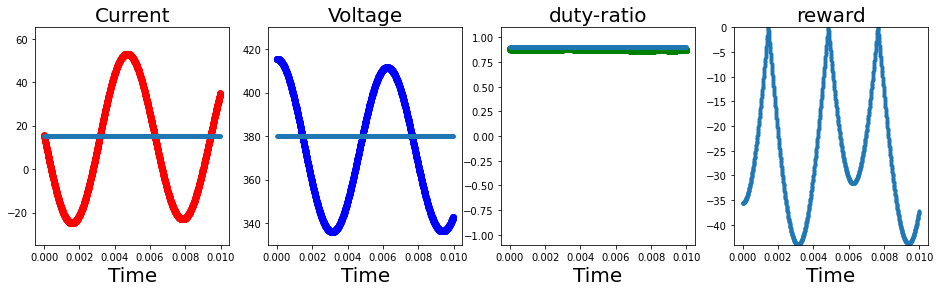

| Reward: -25754 | Episode: 260 | Qmax: -479.7138
| Reward: -14289 | Episode: 261 | Qmax: -481.5699
| Reward: -26864 | Episode: 262 | Qmax: -478.0909
| Reward: -21942 | Episode: 263 | Qmax: -477.3866
| Reward: -18698 | Episode: 264 | Qmax: -480.4802
| Reward: -6891 | Episode: 265 | Qmax: -479.1301
| Reward: -25487 | Episode: 266 | Qmax: -480.0755
| Reward: -20885 | Episode: 267 | Qmax: -478.3493
| Reward: -3863 | Episode: 268 | Qmax: -478.3670
| Reward: -16418 | Episode: 269 | Qmax: -482.9118


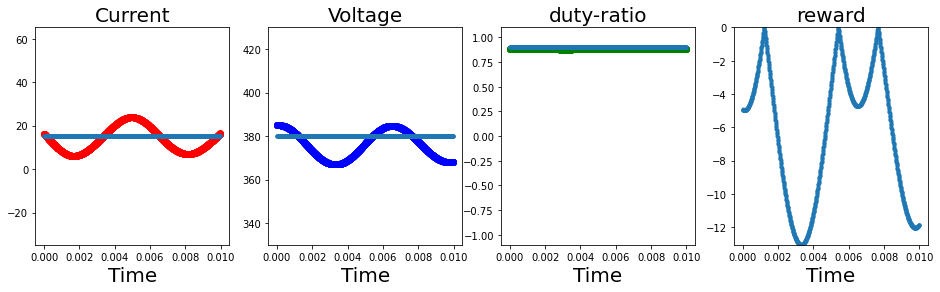

| Reward: -6330 | Episode: 270 | Qmax: -480.5742
| Reward: -13884 | Episode: 271 | Qmax: -479.3168
| Reward: -7151 | Episode: 272 | Qmax: -479.9364
| Reward: -15281 | Episode: 273 | Qmax: -476.8680
| Reward: -20132 | Episode: 274 | Qmax: -475.9371
| Reward: -8480 | Episode: 275 | Qmax: -472.1393
| Reward: -10976 | Episode: 276 | Qmax: -473.7701
| Reward: -9038 | Episode: 277 | Qmax: -472.5661
| Reward: -12828 | Episode: 278 | Qmax: -469.3764
| Reward: -19305 | Episode: 279 | Qmax: -468.1146


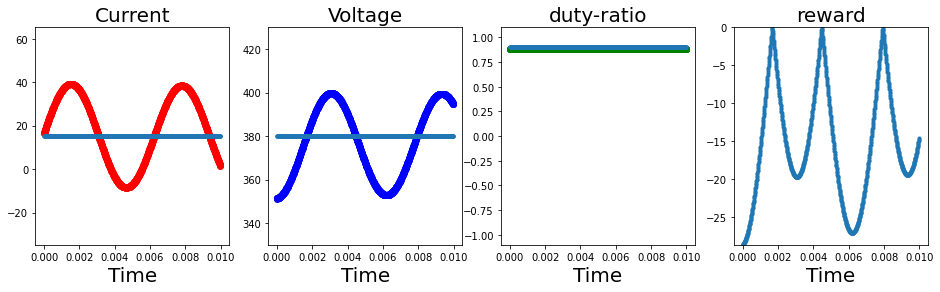

| Reward: -15345 | Episode: 280 | Qmax: -464.5190
| Reward: -15616 | Episode: 281 | Qmax: -462.8609
| Reward: -23177 | Episode: 282 | Qmax: -462.9074
| Reward: -7359 | Episode: 283 | Qmax: -462.9608
| Reward: -15893 | Episode: 284 | Qmax: -460.9965
| Reward: -18136 | Episode: 285 | Qmax: -460.6430
| Reward: -7206 | Episode: 286 | Qmax: -459.6406
| Reward: -6386 | Episode: 287 | Qmax: -455.3580
| Reward: -22230 | Episode: 288 | Qmax: -454.3711
| Reward: -5837 | Episode: 289 | Qmax: -455.0694


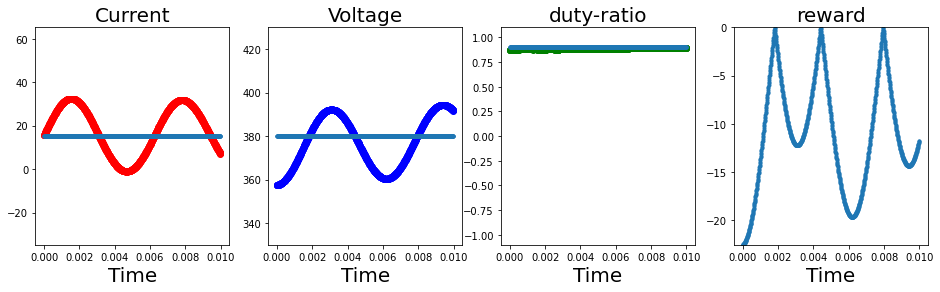

| Reward: -11056 | Episode: 290 | Qmax: -450.9378
| Reward: -2194 | Episode: 291 | Qmax: -448.6976
| Reward: -12925 | Episode: 292 | Qmax: -448.9365
| Reward: -13446 | Episode: 293 | Qmax: -446.1632
| Reward: -22453 | Episode: 294 | Qmax: -446.2725
| Reward: -19187 | Episode: 295 | Qmax: -442.5526
| Reward: -1855 | Episode: 296 | Qmax: -445.6156
| Reward: -9442 | Episode: 297 | Qmax: -444.1295
| Reward: -3821 | Episode: 298 | Qmax: -440.7696
| Reward: -21942 | Episode: 299 | Qmax: -440.4673


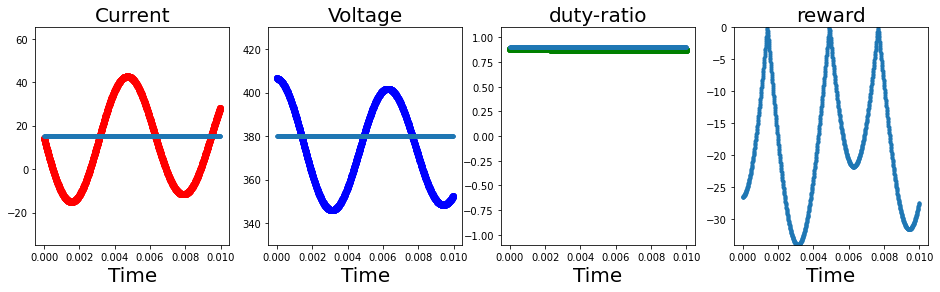

| Reward: -18941 | Episode: 300 | Qmax: -441.2760
| Reward: -24890 | Episode: 301 | Qmax: -439.0829
| Reward: -7980 | Episode: 302 | Qmax: -431.5840
| Reward: -5587 | Episode: 303 | Qmax: -433.6851
| Reward: -12893 | Episode: 304 | Qmax: -430.6061
| Reward: -14537 | Episode: 305 | Qmax: -427.3674
| Reward: -15363 | Episode: 306 | Qmax: -425.0125
| Reward: -7535 | Episode: 307 | Qmax: -423.2890
| Reward: -7273 | Episode: 308 | Qmax: -423.8075
| Reward: -21414 | Episode: 309 | Qmax: -419.5628


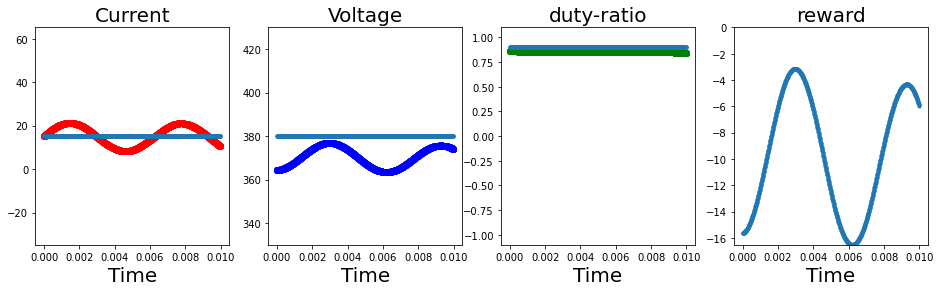

| Reward: -9496 | Episode: 310 | Qmax: -418.1384
| Reward: -12088 | Episode: 311 | Qmax: -416.1085
| Reward: -14062 | Episode: 312 | Qmax: -415.5556
| Reward: -15715 | Episode: 313 | Qmax: -411.9998
| Reward: -15920 | Episode: 314 | Qmax: -408.8953
| Reward: -16055 | Episode: 315 | Qmax: -408.6031
| Reward: -14244 | Episode: 316 | Qmax: -406.4910
| Reward: -31221 | Episode: 317 | Qmax: -403.9172
| Reward: -17421 | Episode: 318 | Qmax: -404.1253
| Reward: -12886 | Episode: 319 | Qmax: -402.3524


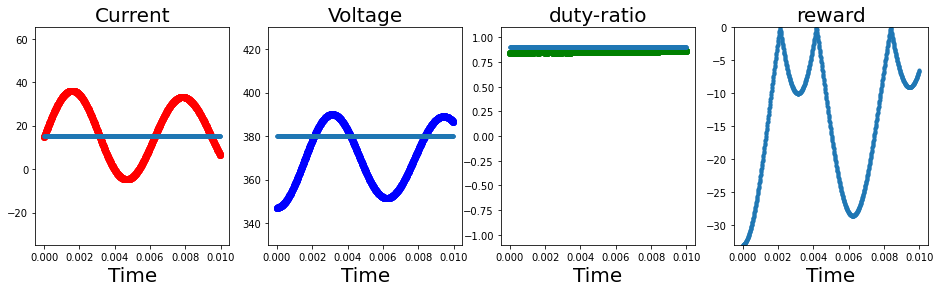

| Reward: -13942 | Episode: 320 | Qmax: -397.3201
| Reward: -8865 | Episode: 321 | Qmax: -395.0399
| Reward: -20324 | Episode: 322 | Qmax: -393.7919
| Reward: -20964 | Episode: 323 | Qmax: -396.4396
| Reward: -16035 | Episode: 324 | Qmax: -394.5010
| Reward: -12103 | Episode: 325 | Qmax: -390.9065
| Reward: -16762 | Episode: 326 | Qmax: -393.4655
| Reward: -15849 | Episode: 327 | Qmax: -393.6621
| Reward: -21498 | Episode: 328 | Qmax: -389.5462
| Reward: -21552 | Episode: 329 | Qmax: -385.1979


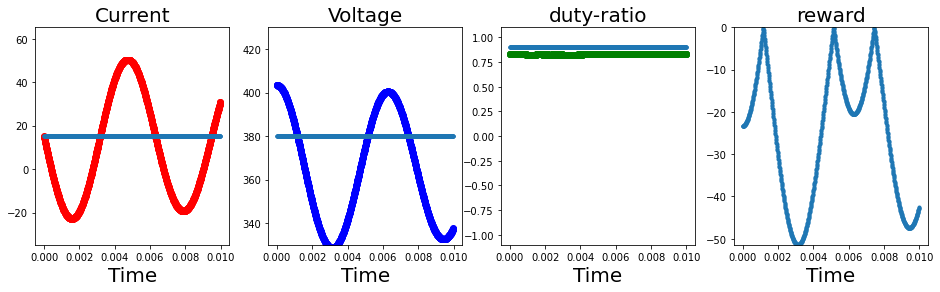

| Reward: -25841 | Episode: 330 | Qmax: -389.1758
| Reward: -23277 | Episode: 331 | Qmax: -389.2897
| Reward: -14816 | Episode: 332 | Qmax: -387.6958
| Reward: -16012 | Episode: 333 | Qmax: -390.6771
| Reward: -15953 | Episode: 334 | Qmax: -386.3711
| Reward: -8676 | Episode: 335 | Qmax: -389.4600
| Reward: -20591 | Episode: 336 | Qmax: -384.9755
| Reward: -6999 | Episode: 337 | Qmax: -385.8417
| Reward: -10260 | Episode: 338 | Qmax: -382.1721
| Reward: -23297 | Episode: 339 | Qmax: -386.1477


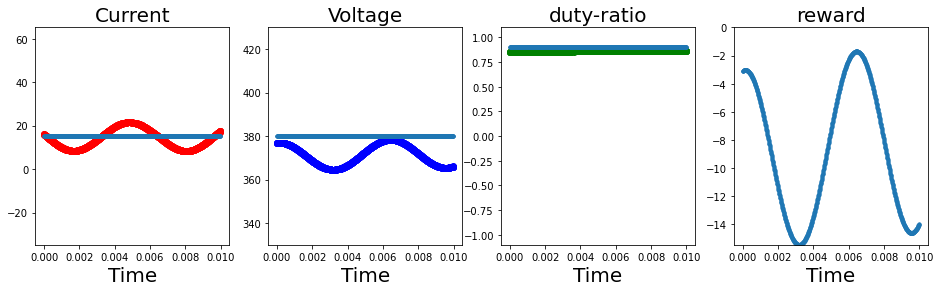

| Reward: -8805 | Episode: 340 | Qmax: -386.1518
| Reward: -10972 | Episode: 341 | Qmax: -385.8607
| Reward: -8015 | Episode: 342 | Qmax: -387.4011
| Reward: -7772 | Episode: 343 | Qmax: -381.7142
| Reward: -13480 | Episode: 344 | Qmax: -385.2157
| Reward: -12429 | Episode: 345 | Qmax: -381.9282
| Reward: -11593 | Episode: 346 | Qmax: -382.8032
| Reward: -9720 | Episode: 347 | Qmax: -381.6658
| Reward: -7777 | Episode: 348 | Qmax: -379.9802
| Reward: -8137 | Episode: 349 | Qmax: -380.7728


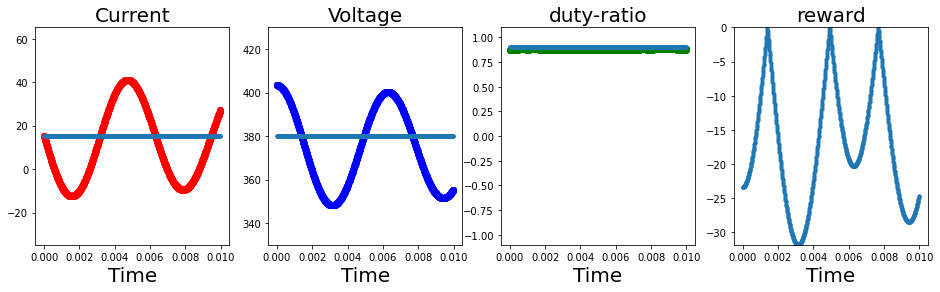

| Reward: -17447 | Episode: 350 | Qmax: -381.4259
| Reward: -21161 | Episode: 351 | Qmax: -379.6607
| Reward: -18450 | Episode: 352 | Qmax: -378.7449
| Reward: -14034 | Episode: 353 | Qmax: -381.7142
| Reward: -11296 | Episode: 354 | Qmax: -384.4384
| Reward: -6676 | Episode: 355 | Qmax: -382.0986
| Reward: -9766 | Episode: 356 | Qmax: -382.2529
| Reward: -18926 | Episode: 357 | Qmax: -381.2428
| Reward: -15125 | Episode: 358 | Qmax: -376.2849
| Reward: -5947 | Episode: 359 | Qmax: -377.5928


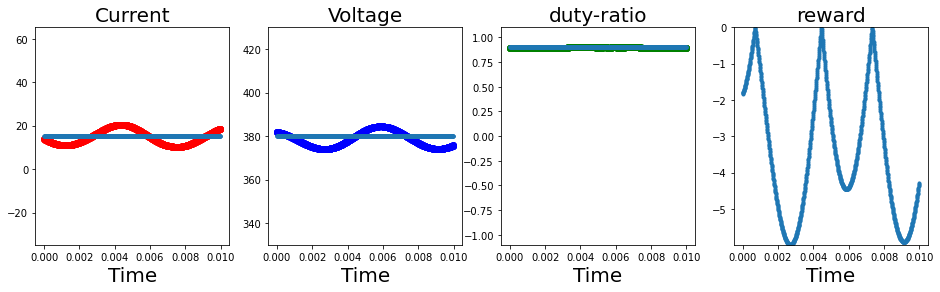

| Reward: -3431 | Episode: 360 | Qmax: -381.0982
| Reward: -12338 | Episode: 361 | Qmax: -375.0244
| Reward: -22305 | Episode: 362 | Qmax: -382.4213
| Reward: -1274 | Episode: 363 | Qmax: -375.5125
| Reward: -14520 | Episode: 364 | Qmax: -376.3199
| Reward: -3257 | Episode: 365 | Qmax: -374.0965
| Reward: -8868 | Episode: 366 | Qmax: -381.4560
| Reward: -7046 | Episode: 367 | Qmax: -373.9221
| Reward: -6579 | Episode: 368 | Qmax: -372.2892
| Reward: -18311 | Episode: 369 | Qmax: -371.5360


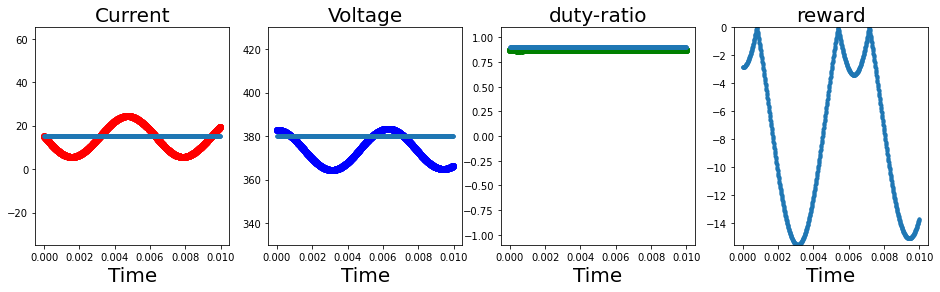

| Reward: -7715 | Episode: 370 | Qmax: -374.5515
| Reward: -11454 | Episode: 371 | Qmax: -373.2286
| Reward: -11882 | Episode: 372 | Qmax: -370.5318
| Reward: -18472 | Episode: 373 | Qmax: -370.3440
| Reward: -24078 | Episode: 374 | Qmax: -370.1306
| Reward: -30724 | Episode: 375 | Qmax: -372.1348
| Reward: -9779 | Episode: 376 | Qmax: -370.7265
| Reward: -8307 | Episode: 377 | Qmax: -371.3383
| Reward: -16719 | Episode: 378 | Qmax: -369.7530
| Reward: -8057 | Episode: 379 | Qmax: -368.1469


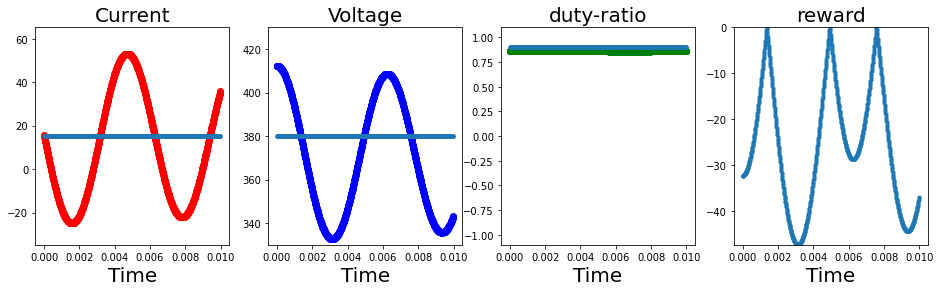

| Reward: -25943 | Episode: 380 | Qmax: -367.4366
| Reward: -16911 | Episode: 381 | Qmax: -372.0644
| Reward: -8559 | Episode: 382 | Qmax: -367.1233
| Reward: -11296 | Episode: 383 | Qmax: -372.3215
| Reward: -20862 | Episode: 384 | Qmax: -368.3457
| Reward: -3918 | Episode: 385 | Qmax: -372.3320
| Reward: -20042 | Episode: 386 | Qmax: -368.2749
| Reward: -5659 | Episode: 387 | Qmax: -366.5104
| Reward: -10351 | Episode: 388 | Qmax: -367.0634
| Reward: -18001 | Episode: 389 | Qmax: -367.5742


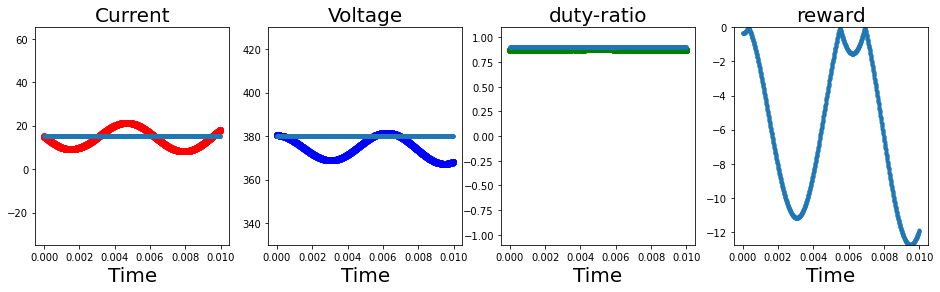

| Reward: -5959 | Episode: 390 | Qmax: -364.3265
| Reward: -19497 | Episode: 391 | Qmax: -361.5544
| Reward: -8766 | Episode: 392 | Qmax: -362.8568
| Reward: -6922 | Episode: 393 | Qmax: -359.7436
| Reward: -19449 | Episode: 394 | Qmax: -363.4041
| Reward: -17821 | Episode: 395 | Qmax: -360.1258
| Reward: -17078 | Episode: 396 | Qmax: -359.4467
| Reward: -16685 | Episode: 397 | Qmax: -361.2550
| Reward: -13809 | Episode: 398 | Qmax: -360.3784
| Reward: -3502 | Episode: 399 | Qmax: -361.1207


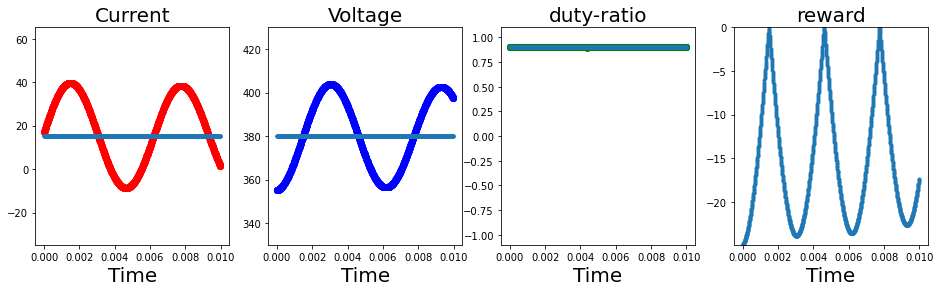

| Reward: -15454 | Episode: 400 | Qmax: -364.0321
| Reward: -14772 | Episode: 401 | Qmax: -359.0405
| Reward: -14786 | Episode: 402 | Qmax: -359.6802
| Reward: -5783 | Episode: 403 | Qmax: -359.0541
| Reward: -15970 | Episode: 404 | Qmax: -359.2643
| Reward: -22429 | Episode: 405 | Qmax: -356.5320
| Reward: -11136 | Episode: 406 | Qmax: -359.9645
| Reward: -16166 | Episode: 407 | Qmax: -361.7039
| Reward: -15683 | Episode: 408 | Qmax: -358.6652
| Reward: -19791 | Episode: 409 | Qmax: -358.3963


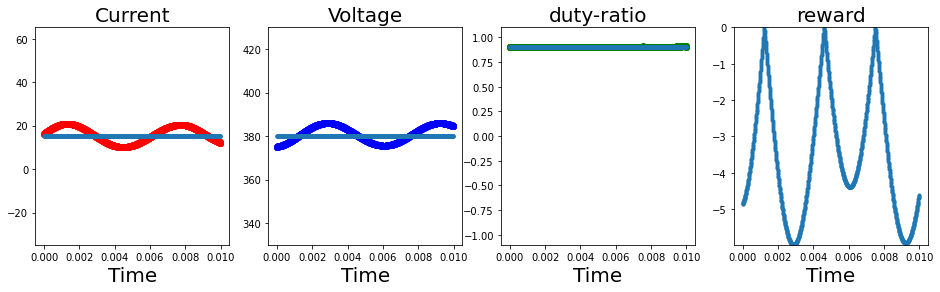

| Reward: -3520 | Episode: 410 | Qmax: -355.2749
| Reward: -4413 | Episode: 411 | Qmax: -362.1656
| Reward: -13081 | Episode: 412 | Qmax: -351.7069
| Reward: -14825 | Episode: 413 | Qmax: -355.4124
| Reward: -18431 | Episode: 414 | Qmax: -354.8786
| Reward: -2879 | Episode: 415 | Qmax: -357.8091
| Reward: -7821 | Episode: 416 | Qmax: -358.3506
| Reward: -17968 | Episode: 417 | Qmax: -354.6211
| Reward: -20142 | Episode: 418 | Qmax: -355.4529
| Reward: -22707 | Episode: 419 | Qmax: -356.5028


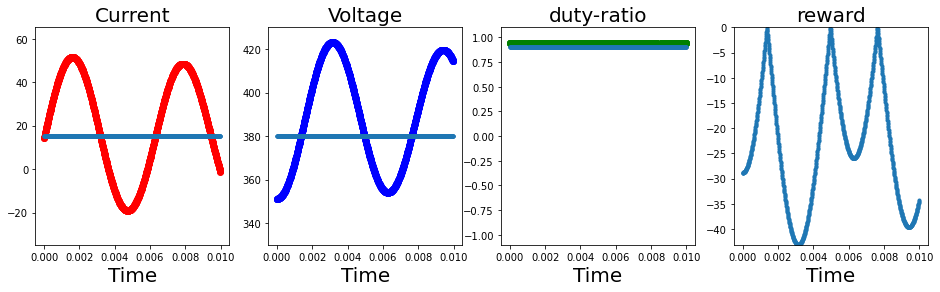

| Reward: -23381 | Episode: 420 | Qmax: -355.7822
| Reward: -14202 | Episode: 421 | Qmax: -354.2878
| Reward: -8805 | Episode: 422 | Qmax: -353.5807
| Reward: -29294 | Episode: 423 | Qmax: -357.4776
| Reward: -22661 | Episode: 424 | Qmax: -350.4649
| Reward: -17684 | Episode: 425 | Qmax: -351.3940
| Reward: -21719 | Episode: 426 | Qmax: -349.4371
| Reward: -25376 | Episode: 427 | Qmax: -355.6558
| Reward: -18829 | Episode: 428 | Qmax: -354.9532
| Reward: -14636 | Episode: 429 | Qmax: -360.5796


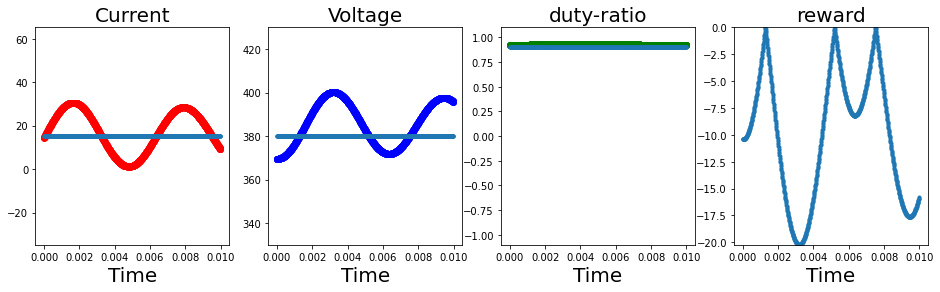

| Reward: -10061 | Episode: 430 | Qmax: -357.2811
| Reward: -10884 | Episode: 431 | Qmax: -352.6053
| Reward: -8708 | Episode: 432 | Qmax: -353.8033
| Reward: -17688 | Episode: 433 | Qmax: -351.5098
| Reward: -11514 | Episode: 434 | Qmax: -358.5282
| Reward: -27366 | Episode: 435 | Qmax: -358.5548
| Reward: -6098 | Episode: 436 | Qmax: -358.5249
| Reward: -9914 | Episode: 437 | Qmax: -358.2174
| Reward: -21003 | Episode: 438 | Qmax: -359.4334
| Reward: -16797 | Episode: 439 | Qmax: -363.4404


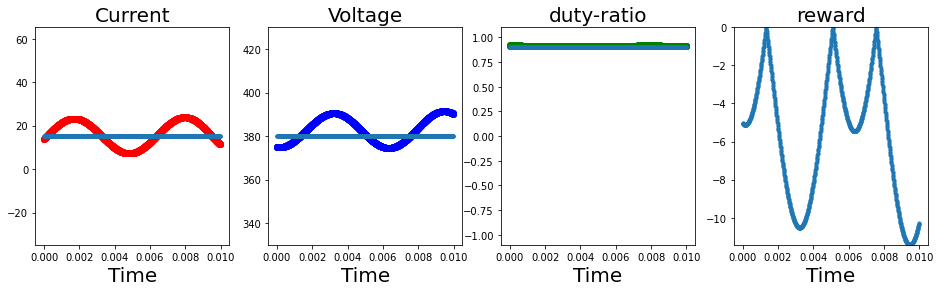

| Reward: -5739 | Episode: 440 | Qmax: -353.6194
| Reward: -7319 | Episode: 441 | Qmax: -360.3746
| Reward: -2643 | Episode: 442 | Qmax: -359.7748
| Reward: -14793 | Episode: 443 | Qmax: -362.0273
| Reward: -9860 | Episode: 444 | Qmax: -358.7464
| Reward: -4408 | Episode: 445 | Qmax: -359.5778
| Reward: -2242 | Episode: 446 | Qmax: -357.5709
| Reward: -16448 | Episode: 447 | Qmax: -360.2797
| Reward: -18968 | Episode: 448 | Qmax: -355.9526
| Reward: -8848 | Episode: 449 | Qmax: -358.7995


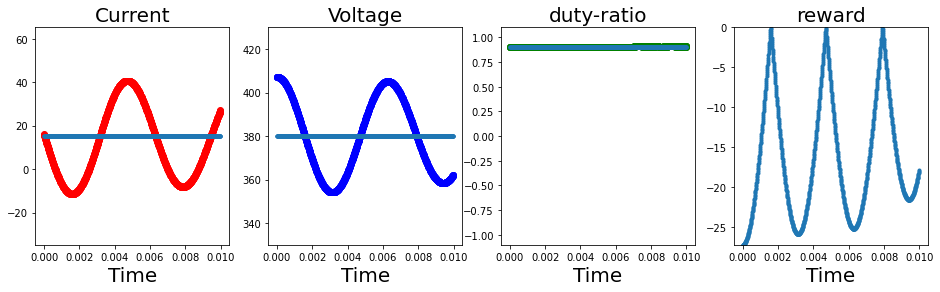

| Reward: -16275 | Episode: 450 | Qmax: -358.6899
| Reward: -19493 | Episode: 451 | Qmax: -359.6214
| Reward: -17548 | Episode: 452 | Qmax: -353.7116
| Reward: -19138 | Episode: 453 | Qmax: -357.4899
| Reward: -24213 | Episode: 454 | Qmax: -356.7823
| Reward: -22807 | Episode: 455 | Qmax: -360.1685
| Reward: -7961 | Episode: 456 | Qmax: -357.6513
| Reward: -19212 | Episode: 457 | Qmax: -357.8430
| Reward: -10481 | Episode: 458 | Qmax: -359.7842
| Reward: -6304 | Episode: 459 | Qmax: -356.5669


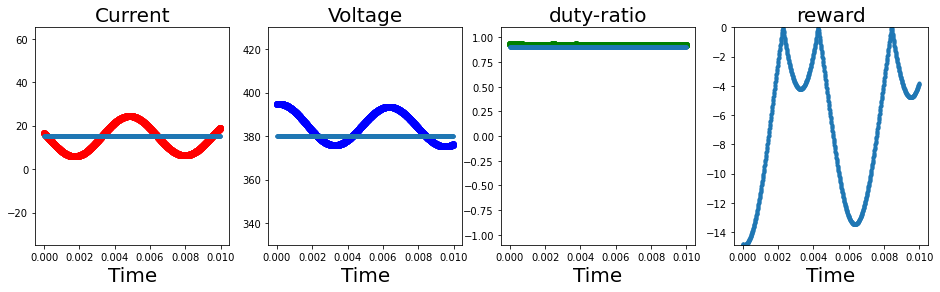

| Reward: -6630 | Episode: 460 | Qmax: -356.3974
| Reward: -17881 | Episode: 461 | Qmax: -355.2553
| Reward: -24746 | Episode: 462 | Qmax: -357.0569
| Reward: -6280 | Episode: 463 | Qmax: -354.7929
| Reward: -14797 | Episode: 464 | Qmax: -356.6667
| Reward: -8715 | Episode: 465 | Qmax: -351.9934
| Reward: -22402 | Episode: 466 | Qmax: -356.0003
| Reward: -6322 | Episode: 467 | Qmax: -352.0432
| Reward: -17627 | Episode: 468 | Qmax: -355.0402
| Reward: -20676 | Episode: 469 | Qmax: -354.5927


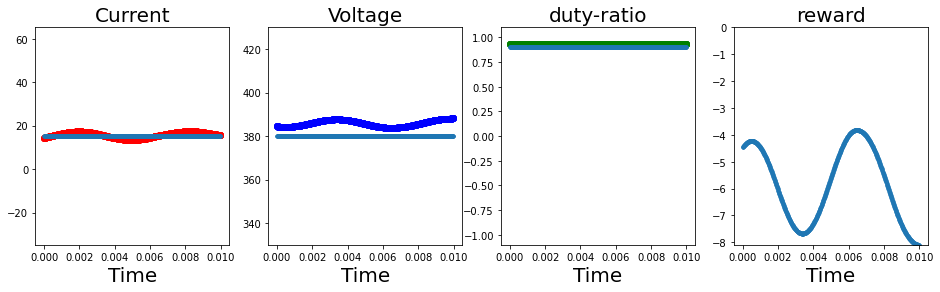

| Reward: -5806 | Episode: 470 | Qmax: -353.6278
| Reward: -27004 | Episode: 471 | Qmax: -351.5575
| Reward: -25405 | Episode: 472 | Qmax: -354.2989
| Reward: -5576 | Episode: 473 | Qmax: -354.6527
| Reward: -14503 | Episode: 474 | Qmax: -354.5764
| Reward: -15688 | Episode: 475 | Qmax: -349.7673
| Reward: -7050 | Episode: 476 | Qmax: -354.1625
| Reward: -22858 | Episode: 477 | Qmax: -351.9218
| Reward: -25746 | Episode: 478 | Qmax: -346.6791
| Reward: -8150 | Episode: 479 | Qmax: -351.9136


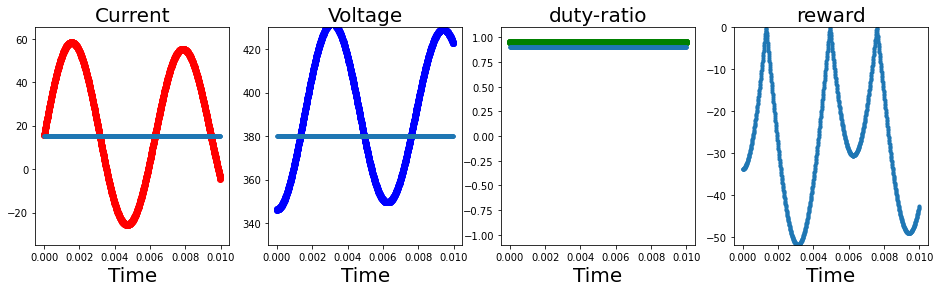

| Reward: -28134 | Episode: 480 | Qmax: -345.3910
| Reward: -10604 | Episode: 481 | Qmax: -351.7428
| Reward: -13432 | Episode: 482 | Qmax: -345.2683
| Reward: -13410 | Episode: 483 | Qmax: -350.7745
| Reward: -26271 | Episode: 484 | Qmax: -347.6171
| Reward: -11737 | Episode: 485 | Qmax: -349.4889
| Reward: -28119 | Episode: 486 | Qmax: -353.2437
| Reward: -10526 | Episode: 487 | Qmax: -348.9652
| Reward: -10914 | Episode: 488 | Qmax: -346.0058
| Reward: -16650 | Episode: 489 | Qmax: -349.2667


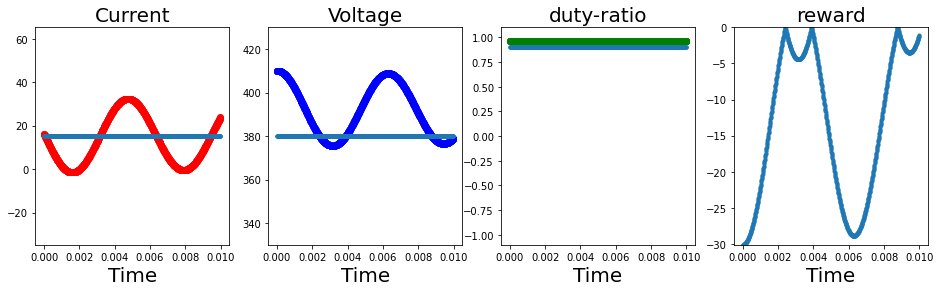

| Reward: -13197 | Episode: 490 | Qmax: -353.1665
| Reward: -22281 | Episode: 491 | Qmax: -345.8686
| Reward: -21394 | Episode: 492 | Qmax: -347.9483


In [ ]:
with tf.Session() as sess:
 
    env = Buck_Converter_n()#gym.make(args['env'])
    np.random.seed(int(args['random_seed']))
    tf.set_random_seed(int(args['random_seed']))
    env.seed(int(args['random_seed']))
 
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = env.action_space.high
    # Ensure action bound is symmetric
    assert (env.action_space.high == -env.action_space.low)
 
    actor = ActorNetwork(sess, state_dim, action_dim, action_bound,
                            float(args['actor_lr']), float(args['tau']),
                            int(args['minibatch_size']))
 
    critic = CriticNetwork(sess, state_dim, action_dim,
                            float(args['critic_lr']), float(args['tau']),
                            float(args['gamma']),
                            actor.get_num_trainable_vars())
    
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))
 
    if args['use_gym_monitor']:
        if not args['render_env']:
            env = wrappers.Monitor(
                env, args['monitor_dir'], video_callable=False, force=True)
        else:
            env = wrappers.Monitor(env, args['monitor_dir'], force=True)
    
    reward_result = np.zeros(2500) 
    summary_ops, summary_vars, paths = train(sess, env, args, actor, critic, actor_noise, reward_result)
 
    if args['use_gym_monitor']:
        env.monitor.close()